## [CS5228 - Project 37] Task 1: Prediction of Property Prices

Group Members:
- A0255968H – Drishti Sanjay Jain
- A0142949U – Gin Wen Ng
- A0172938R – Jialin Liu
- A0254393Y – Michael

### ML Pipeline
0. [Set-Up](#set-up)  
    0.1. [Imports](#su-imports)  
    0.2. [Data Extraction](#su-de)
1. [EDA](#eda)
2. [Data Pre-Processing](#dp)
3. [Feature Engineering](#fe)  
    3.1. [Feature Extraction](#fe-fx)  
    3.2. [Feature Selection](#fe-fs)  
    3.3. [Data Splitting](#fe-ds)
4. [Modelling](#m)  
    4.1. [Model Exploration](#m-me)  
    4.2. [Optimised Feature Selection](#m-ofs)  
    4.3. [Hyperparameter Optimisation](#m-hpo)
    <ul>
        <a href = "#m-hpo-a">4.3.a. First Approach – hyperopt-sklearn</a><br>
        <a href = "#m-hpo-b">4.3.b. Second Approach – hyperopt</a>
    </ul><br>
5. [Performance Evaluation](#pe)  
    5.1. [Local Test (*X_test*)](#pe-lt)  
    5.2. [Test Dataset (*test.csv*)](#pe-td)
6. [Other Approaches](#oa)

**0. Set-Up** <a id = "set-up"></a>

**0.1. Imports** <a id = "su-imports"></a>

In [1]:
import sys, time, pickle, math
from collections import OrderedDict
from functools import partial

print(f"Python - {'.'.join(str(ver) for ver in sys.version_info[:4])}\n")

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import sklearn
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, RepeatedKFold, HalvingGridSearchCV
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, make_scorer
from sklearn.pipeline import make_pipeline, Pipeline

import xgboost

import hyperopt
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope

from hpsklearn import HyperoptEstimator, random_forest_regressor

import geopy
from geopy.geocoders import Nominatim
import reverse_geocode

print(f"""Libraries:\n{np.__name__} - {np.__version__}\n{pd.__name__} - {pd.__version__}
{mpl.__name__}, {plt.__name__} - {mpl.__version__}\n{sns.__name__} - {sns.__version__}\n{statsmodels.__name__} - {statsmodels.__version__}
{sklearn.__name__} - {sklearn.__version__}\n{xgboost.__name__} - {xgboost.__version__}\n{hyperopt.__name__} - {hyperopt.__version__}
hyperopt-sklearn\n{geopy.__name__} - {geopy.__version__}\nreverse_geocode - 1.4.1""")

Python - 3.10.6.final

Libraries:
numpy - 1.23.3
pandas - 1.5.0
matplotlib, matplotlib.pyplot - 3.6.1
seaborn - 0.12.0
statsmodels - 0.13.2
sklearn - 1.1.2
xgboost - 1.6.2
hyperopt - 0.2.7
hyperopt-sklearn
geopy - 2.2.0
reverse_geocode - 1.4.1


**0.2. Data Extraction** <a id = "su-de"></a>

In [2]:
df_clean = pd.read_csv('../data/train_with_features.csv')
df_test = pd.read_csv('../data/test_with_features.csv')

In [3]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20149 entries, 0 to 20148
Data columns (total 57 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   listing_id                        20149 non-null  int64  
 1   title                             20149 non-null  object 
 2   address                           20149 non-null  object 
 3   property_name                     20149 non-null  object 
 4   property_type                     20149 non-null  object 
 5   tenure                            20149 non-null  object 
 6   num_beds                          20149 non-null  float64
 7   num_baths                         20149 non-null  float64
 8   size_sqft                         20149 non-null  float64
 9   property_details_url              20149 non-null  object 
 10  lat                               20149 non-null  float64
 11  lng                               20149 non-null  float64
 12  subz

In [4]:
print(f'Nonnumerical Features: {df_clean.select_dtypes(exclude = [np.number]).columns.to_list()}')

Nonnumerical Features: ['title', 'address', 'property_name', 'property_type', 'tenure', 'property_details_url', 'subzone', 'planning_area']


**1. EDA** <a id = "eda"></a>

Out of the 8 nonnumerical features shown above, relevant features to be converted to numerical features during *Feature Extraction* are `property_type` and `tenure`. `subzone` and `planning_area` are relevant features but will be ignored here as derived features are present from the initial feature engineering.

First, visualise the number of flats for each `property_type`.

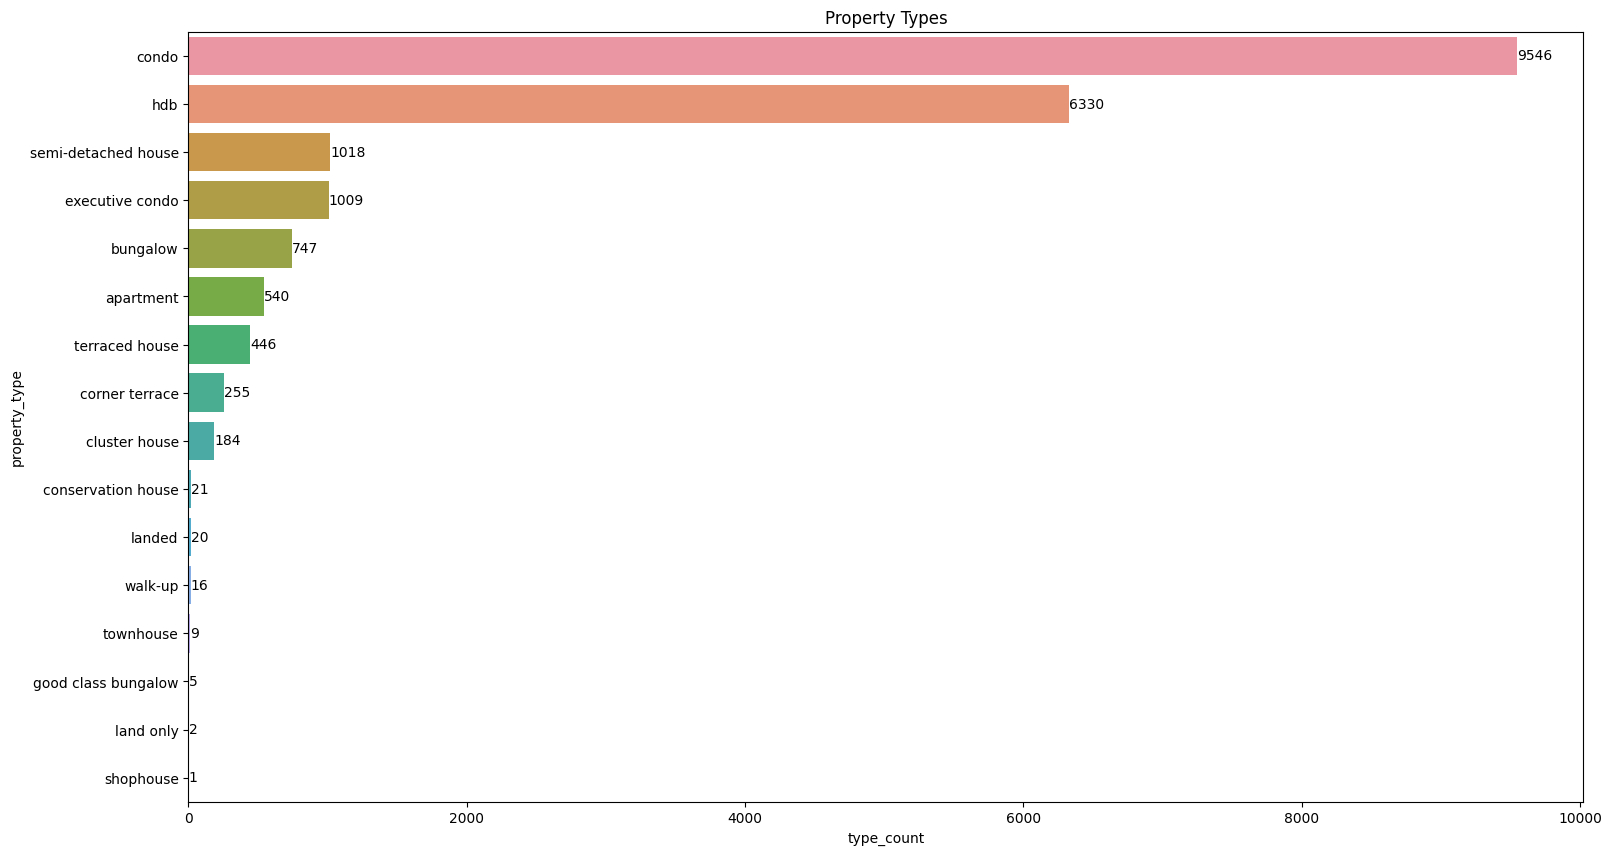

In [5]:
fig, ax = plt.subplots(figsize = (18, 10))
property_types = df_clean['property_type'].value_counts().to_frame().reset_index()
property_types.columns = ['property_type', 'type_count']

ax.set_title('Property Types')
sns.barplot(x = 'type_count', y = 'property_type', data = property_types)
ax.bar_label(ax.containers[0])

plt.show()

The bar graph above shows a skewed distribution. We need to check if flats are correctly classified; therefore, check if `property_type` is consistent for a given `property_name`.

In [6]:
df_clean['property_name'].value_counts()[:5]

hdb-woodlands      312
leedon green       308
the gazania        287
hyll on holland    285
riviere            258
Name: property_name, dtype: int64

In [7]:
df_clean[df_clean['property_name'] == 'leedon green']['property_type'].value_counts()

condo        307
apartment      1
Name: property_type, dtype: int64

The `property_type` is not consistent for a given `property_name`. A `property_name` such as `leedon green` must be of a fixed `property_type` (condo), whereas if it is a street name, it can be of multiple `property_type`s (for example, bungalow or landed).

During [*Data Pre-Processing*](#dp-pt), we have to ensure that it is consistent, especially for hdb/executive condo/condo/apartment flats.

Second, visualise the distribution of `tenure`.

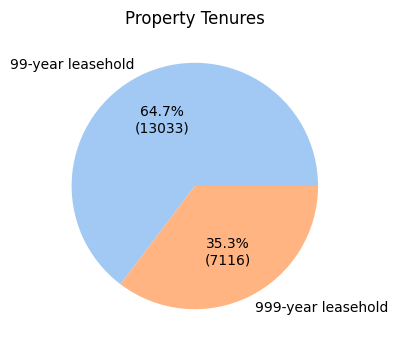

In [8]:
# Source: matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig, ax = plt.subplots(figsize = (8, 4))
property_tenure = df_clean['tenure'].value_counts().to_frame().reset_index()
property_tenure.columns = ['property_tenure', 'tenure_count']

ax.set_title('Property Tenures')
plt.pie(property_tenure['tenure_count'], labels = property_tenure['property_tenure'], colors = sns.color_palette('pastel'), autopct = lambda pct: func(pct, property_tenure['tenure_count']))

plt.show()

The pie chart above shows a reasonable distribution as most properties in Singapore are 99-year leasehold.

During [*Feature Extraction*](#fe-t), dummy encoding should suffice.

Next, check if the geographical coordinates (latitude and longitude) of all properties match Singapore by reverse geocoding.

In [9]:
df_clean['country'] = [result['country'] for result in reverse_geocode.search(df_clean[['lat', 'lng']].agg(tuple, axis = 1).to_list())]
print(f'df_clean Initial Countries: {df_clean["country"].value_counts().index.to_list()}')

df_clean Initial Countries: ['Singapore', 'Malaysia', 'Philippines', 'United States', 'Norway']


Not all geographical coordinates match Singapore.

During [*Data Pre-Processing*](#dp-gc), we have to ensure that it is consistent and all geographical coordinates must match Singapore.

**2. Data Pre-Processing** <a id = "dp"></a>

<a id = "dp-pt"></a>

First, ensure that `property_type` values are consistent for hdb/executive condo/condo/apartment flats by taking the majority `property_type` for each `property_name` that is a hdb/executive condo/condo/apartment flat.

In [10]:
property_type_dict = {}

for property_name, count in df_clean['property_name'].value_counts().items():
    property_types = df_clean[df_clean['property_name'] == property_name]['property_type']
    majority = property_types.value_counts().sort_values(ascending = False).index[0]

    if majority in ['hdb', 'executive condo', 'condo', 'apartment'] and property_types.value_counts().shape[0] > 1:
        df_clean.loc[property_types.index, 'property_type'] = majority
        property_type_dict[property_name] = majority

Apply to `df_test` using the same transformation (`property_type_dict`).

In [11]:
for property_name in df_test['property_name'].value_counts().index:
    if property_type_dict.get(property_name, None):
        property_types = df_test[df_test['property_name'] == property_name]
        df_test.loc[property_types.index, 'property_type'] = property_type_dict[property_name]

To ensure that the pre-processing `property_type` was appropriate, re-visualise the number of flats for each `property_type`.

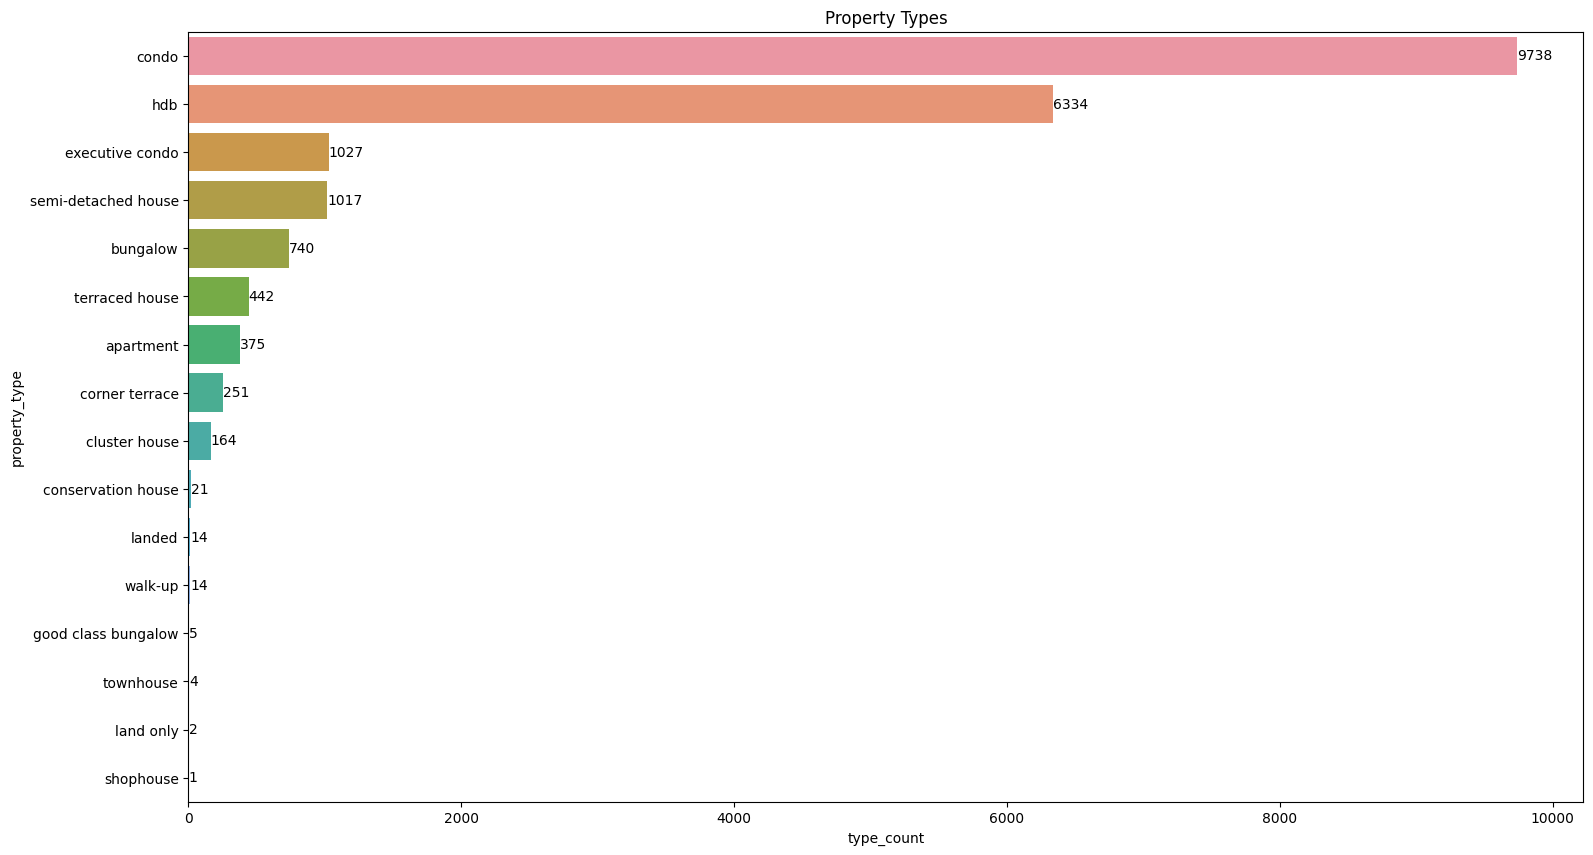

In [12]:
fig, ax = plt.subplots(figsize = (18, 10))
property_types = df_clean['property_type'].value_counts().to_frame().reset_index()
property_types.columns = ['property_type', 'type_count']

ax.set_title('Property Types')
sns.barplot(x = 'type_count', y = 'property_type', data = property_types)
ax.bar_label(ax.containers[0])

plt.show()

<a id = "dp-gc"></a>

Second, ensure that `lat` and `lng` values are consistent and match Singapore by geocoding (using geopy Nominatim's geocode function) the address and property name. If there are no matches, geocode the subzone instead. Exclude Malaysia as Singapore and Malaysia are close to each other and there is no web-based API within `reverse_geocode` library for quick geocoding.

In [13]:
%%time
geolocator = Nominatim(user_agent = 'task1', timeout = 2) # Increase timeout if GeocoderTimedOut error
property_coord_dict = {}

for index in df_clean[~df_clean['country'].isin(['Singapore', 'Malaysia'])].index:
    get_coord = property_coord_dict.get(df_clean.loc[index, 'property_name'], None)
    if get_coord:
        df_clean.loc[index, 'lat'] = get_coord['lat']
        df_clean.loc[index, 'lng'] = get_coord['lon']
        continue
    
    query = df_clean.loc[index, 'property_name'] + ' ' + df_clean.loc[index, 'address'] + ' Singapore'
    result = geolocator.geocode(query)
    
    if not result:
        query = df_clean.loc[index, 'subzone'] + ' Singapore'
        result = geolocator.geocode(query)
    
    if result:
        result = result.raw
        df_clean.loc[index, 'lat'] = float(result['lat'])
        df_clean.loc[index, 'lng'] = float(result['lon'])
        property_coord_dict[df_clean.loc[index, 'property_name']] = {'lat': float(result['lat']), 'lon': float(result['lon'])}
        
df_clean['country'] = [result['country'] for result in reverse_geocode.search(df_clean[['lat', 'lng']].agg(tuple, axis = 1).to_list())]
print(f'df_clean Final Countries: {df_clean["country"].value_counts().index.to_list()}')
df_clean.drop('country', axis = 1, inplace = True)

df_clean Final Countries: ['Singapore', 'Malaysia']
CPU times: total: 984 ms
Wall time: 4.98 s


Now that all geographical coordinates match Singapore, apply to  `df_test` using the same transformation (`property_coord_dict`).

In [14]:
df_test['country'] = [result['country'] for result in reverse_geocode.search(df_test[['lat', 'lng']].agg(tuple, axis = 1).to_list())]
print(f'df_test Initial Countries: {df_test["country"].value_counts().index.to_list()}')

for index in df_test[~df_test['country'].isin(['Singapore', 'Malaysia'])].index:
    coord = property_coord_dict[df_test.loc[index, 'property_name']]
    df_test.loc[index, 'lat'] = coord['lat']
    df_test.loc[index, 'lng'] = coord['lon']
    
df_test['country'] = [result['country'] for result in reverse_geocode.search(df_test[['lat', 'lng']].agg(tuple, axis = 1).to_list())]
print(f'df_test Final Countries: {df_test["country"].value_counts().index.to_list()}')
df_test.drop('country', axis = 1, inplace = True)

df_test Initial Countries: ['Singapore', 'Malaysia', 'Philippines', 'United States', 'Norway']
df_test Final Countries: ['Singapore', 'Malaysia']


**3. Feature Engineering** <a id = "fe"></a>

**3.1. Feature Extraction** <a id = "fe-fx"></a>

After *Data Pre-Processing*, visualise the distribution of `price`s for each `property_type`.

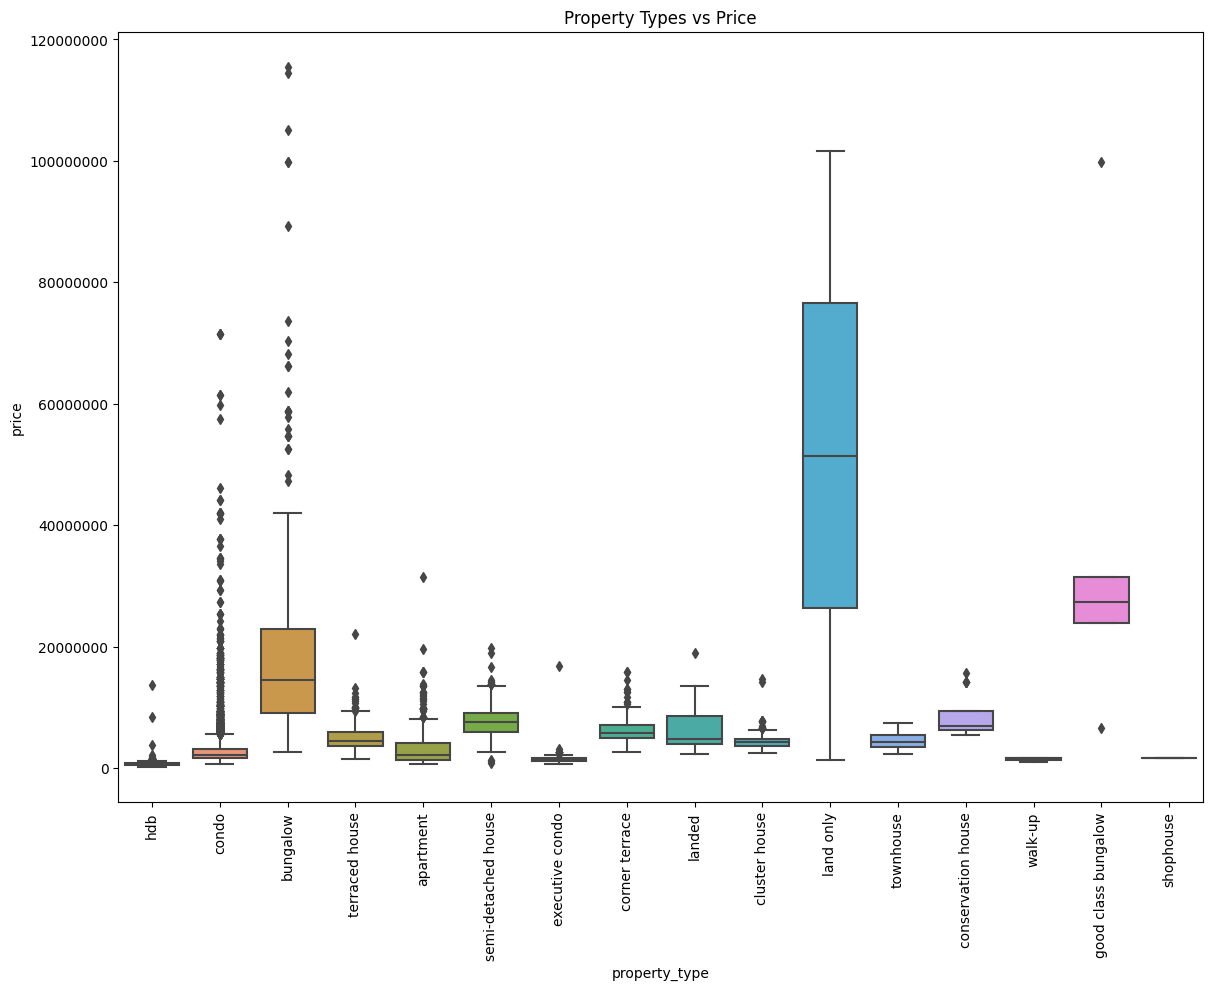

In [15]:
fig, ax = plt.subplots(figsize = (14, 10))
ax.ticklabel_format(style = 'plain', axis = 'y')
ax.tick_params(axis = 'x', rotation = 90)

ax.set_title('Property Types vs Price')
sns.boxplot(x = 'property_type', y = 'price', data = df_clean)

plt.show()

Referring to the box plot above, there are `property_type` values with similar price distributions. Group similar distributions to reduce data cardinality before encoding.

In [16]:
df_clean['property_type'].replace(['executive condo', 'walk-up', 'shophouse'], 
                                  'executive condo/walk-up/shophouse', inplace = True)
df_clean['property_type'].replace(['condo', 'apartment'], 
                                  'condo/apartment', inplace = True)
df_clean['property_type'].replace(['terraced house', 'cluster house', 'townhouse'], 
                                  'terraced house/cluster house/townhouse', inplace = True)
df_clean['property_type'].replace(['corner terrace', 'landed'], 
                                  'corner terrace/landed', inplace = True)
df_clean['property_type'].replace(['semi-detached house', 'conservation house'], 
                                  'semi-detached house/conservation house', inplace = True)

Apply to `df_test` using the same groupings of similar distributions.

In [17]:
df_test['property_type'].replace(['executive condo', 'walk-up', 'shophouse'], 
                                  'executive condo/walk-up/shophouse', inplace = True)
df_test['property_type'].replace(['condo', 'apartment'], 
                                  'condo/apartment', inplace = True)
df_test['property_type'].replace(['terraced house', 'cluster house', 'townhouse'], 
                                  'terraced house/cluster house/townhouse', inplace = True)
df_test['property_type'].replace(['corner terrace', 'landed'], 
                                  'corner terrace/landed', inplace = True)
df_test['property_type'].replace(['semi-detached house', 'conservation house'], 
                                  'semi-detached house/conservation house', inplace = True)

Perform label (ordinal) encoding for `property_type` due to its high cardinality (performing one-hot encoding will significantly increase data dimensionality). Create categories in ascending order based on mean price of each property type.

In [18]:
encode_categories = df_clean['price'].groupby(df_clean['property_type']).mean().sort_values().reset_index().drop('price', axis = 1).reset_index()
encode_categories['index'] += 1
encode_categories = encode_categories.set_index('property_type').squeeze()
encode_categories

property_type
hdb                                       1
executive condo/walk-up/shophouse         2
condo/apartment                           3
terraced house/cluster house/townhouse    4
corner terrace/landed                     5
semi-detached house/conservation house    6
bungalow                                  7
good class bungalow                       8
land only                                 9
Name: index, dtype: int64

The above ordinal encoding makes sense from the lowest price (hdb) to the highest price (land only). Perform ordinal encoding.

In [19]:
df_clean['property_type'] = df_clean['property_type'].map(encode_categories)
df_clean['property_type']

0        1
1        1
2        3
3        3
4        3
        ..
20144    3
20145    3
20146    3
20147    1
20148    3
Name: property_type, Length: 20149, dtype: int64

Apply to `df_test` using the same ordinal encoding (`encode_categories`).

In [20]:
df_test['property_type'] = df_test['property_type'].map(encode_categories)

<a id = "fe-t"></a>

Next, perform dummy encoding for `tenure` and rename to `999-year leasehold` as there are only 2 unique values. One-hot encoding may not be necessary.

In [21]:
df_clean['tenure'] = pd.get_dummies(df_clean['tenure'], drop_first = True).squeeze()
df_clean.rename(columns = {'tenure': '999-year leasehold'}, inplace = True)
df_clean['999-year leasehold']

0        0
1        0
2        1
3        1
4        0
        ..
20144    0
20145    1
20146    1
20147    0
20148    1
Name: 999-year leasehold, Length: 20149, dtype: uint8

Apply to `df_test` using the same dummy encoding.

In [22]:
df_test['tenure'] = pd.get_dummies(df_test['tenure'], drop_first = True).squeeze()
df_test.rename(columns = {'tenure': '999-year leasehold'}, inplace = True)

After *Feature Extraction*, `df_clean` and `df_test` should only contain numeric values as `Task 1` is a `regression` task. Furthermore, remove `listing_id` as it is a nominal attribute.

In [23]:
df_clean = df_clean.select_dtypes(include = [np.number])
df_clean.drop('listing_id', axis = 1, inplace = True)

df_test = df_test.select_dtypes(include = [np.number])
df_test.drop('listing_id', axis = 1, inplace = True)

**3.2. Feature Selection** <a id = "fe-fs"></a>

After *Feature Extraction*, plot a heatmap to visually inspect (and later remove) features that are highly correlated (lightest/darkest colour) with each other.

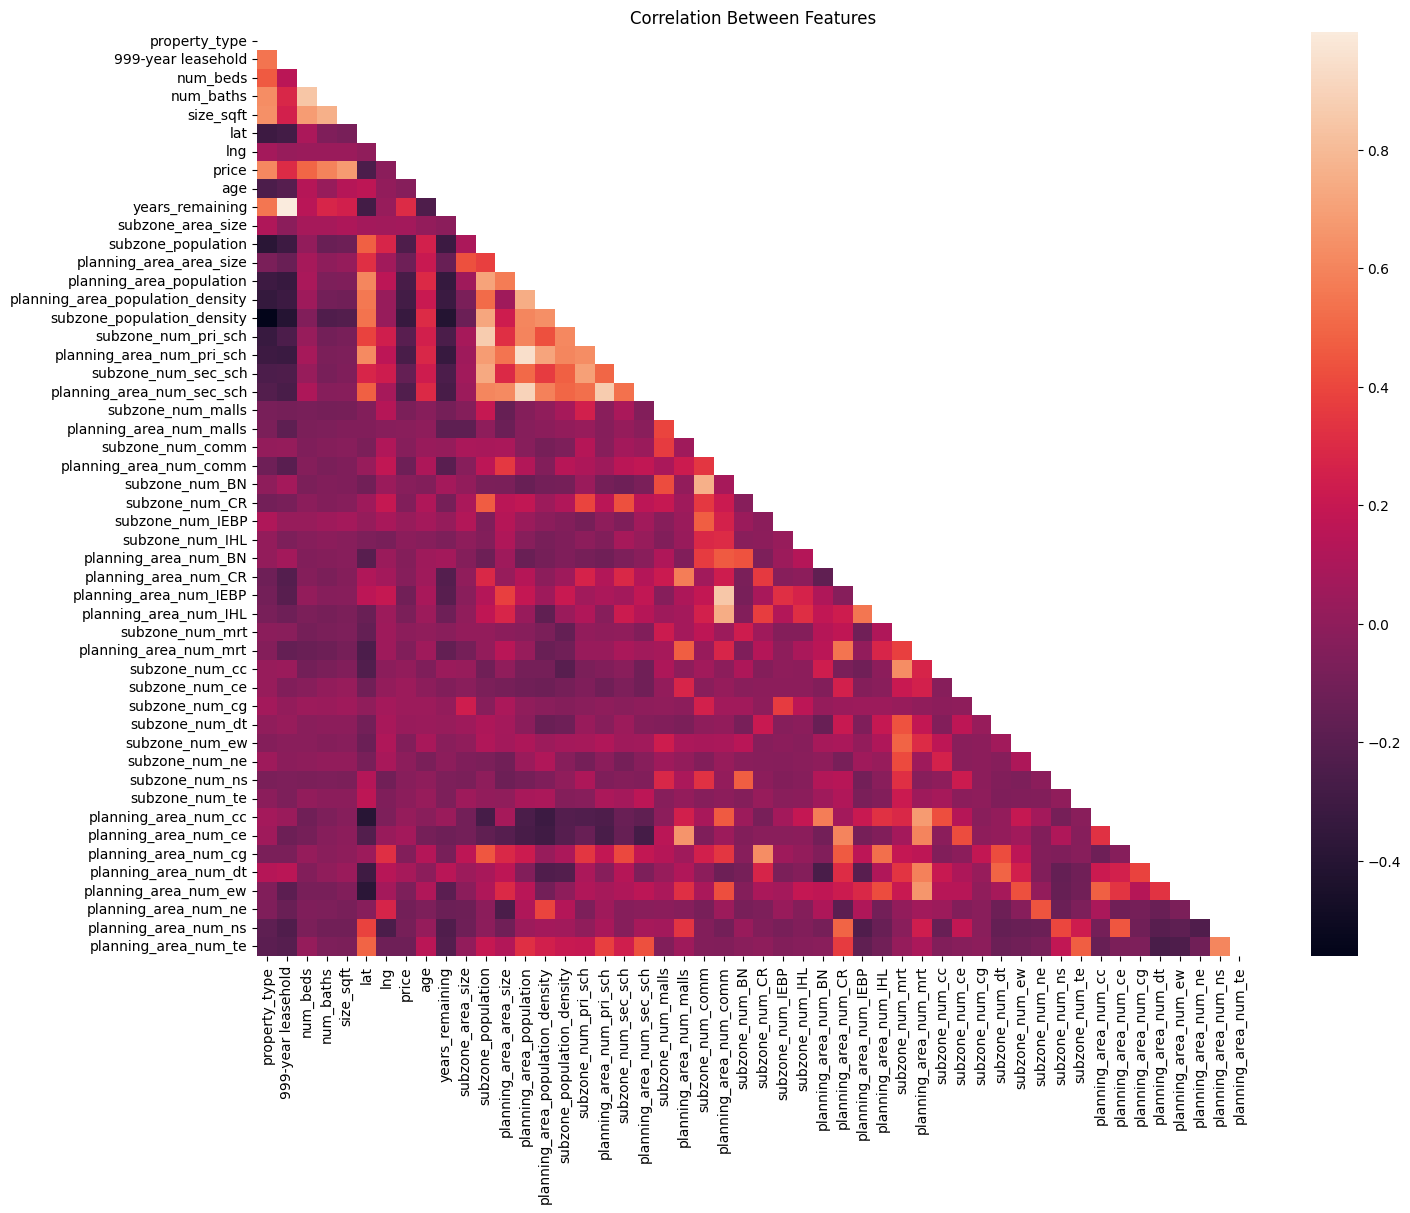

In [24]:
fig, ax = plt.subplots(figsize = (16, 12))

ax.set_title('Correlation Between Features')
sns.heatmap(df_clean.corr(), mask = np.triu(df_clean.corr()))

plt.show()

Find out feature pairs that are highly correlated. Set the threshold to `0.7`, so a feature pair is considered highly correlated if its correlation threshold is greater than `0.7`.

In [25]:
correlation_pairs = abs(df_clean.corr()).unstack().sort_values(ascending = False)[df_clean.shape[1]:]
correlation_pairs = correlation_pairs[correlation_pairs > 0.7]
correlation_pairs = correlation_pairs[~pd.DataFrame(np.sort(np.array(correlation_pairs.index.tolist()))).duplicated().values]
correlation_pairs

years_remaining                   999-year leasehold                  0.999423
planning_area_population          planning_area_num_pri_sch           0.947705
planning_area_num_sec_sch         planning_area_population            0.900357
planning_area_num_pri_sch         planning_area_num_sec_sch           0.871341
subzone_num_pri_sch               subzone_population                  0.868160
planning_area_num_comm            planning_area_num_IEBP              0.851642
num_beds                          num_baths                           0.841702
subzone_num_comm                  subzone_num_BN                      0.761454
num_baths                         size_sqft                           0.756781
planning_area_population_density  planning_area_population            0.746504
planning_area_num_IHL             planning_area_num_comm              0.745321
subzone_population                subzone_num_sec_sch                 0.735582
                                  subzone_population

In [26]:
correlated_features = list(OrderedDict.fromkeys([item for sublist in correlation_pairs.index for item in sublist]))
print(f'Highly correlated features ({len(correlated_features)}): {correlated_features}')

Highly correlated features (18): ['years_remaining', '999-year leasehold', 'planning_area_population', 'planning_area_num_pri_sch', 'planning_area_num_sec_sch', 'subzone_num_pri_sch', 'subzone_population', 'planning_area_num_comm', 'planning_area_num_IEBP', 'num_beds', 'num_baths', 'subzone_num_comm', 'subzone_num_BN', 'size_sqft', 'planning_area_population_density', 'planning_area_num_IHL', 'subzone_num_sec_sch', 'subzone_population_density']


To remove highly correlated features accurately, we will calculate the Variance Inflation Factor (VIF) between highly correlated features. Here, we consider a `VIF threshold` of greater than `10` as an indicator of multicollinearity. Repeat calculating the VIF and removing features one by one until all VIF values are less than `10`.

In [27]:
def calculate_vif(features):
    df = add_constant(df_clean[features])
    df = pd.DataFrame([[df.columns[i], variance_inflation_factor(df.values, i)] for i in range(len(df.columns))], columns = ['Feature', 'VIF'])
    return df[df['Feature'] != 'const'].sort_values('VIF', ascending = False)

In [28]:
calculate_vif(correlated_features)

,Feature,VIF
1,years_remaining,1046.666022
2,999-year leasehold,1040.333630
3,planning_area_population,21.127548
4,planning_area_num_pri_sch,12.533045
7,subzone_population,8.194109
5,planning_area_num_sec_sch,7.422910
8,planning_area_num_comm,7.375868
9,planning_area_num_IEBP,5.162019
6,subzone_num_pri_sch,4.953759
11,num_baths,4.853620


Firstly, `years_remaining` and `999-year leasehold` have extremely high VIF values. In this case, `999-year leasehold` will be removed first as `years_remaining` may provide more information about a listing.

In [29]:
correlated_features.remove('999-year leasehold')
calculate_vif(correlated_features)

,Feature,VIF
2,planning_area_population,21.024207
3,planning_area_num_pri_sch,12.480403
6,subzone_population,8.104325
4,planning_area_num_sec_sch,7.398560
7,planning_area_num_comm,7.323649
8,planning_area_num_IEBP,5.106876
5,subzone_num_pri_sch,4.924417
10,num_baths,4.789015
9,num_beds,3.937835
12,subzone_num_BN,3.422664


Next, remove `planning_area_population` as it indicates the highest VIF value.

In [30]:
correlated_features.remove('planning_area_population')
calculate_vif(correlated_features)

,Feature,VIF
2,planning_area_num_pri_sch,7.458687
6,planning_area_num_comm,7.242924
5,subzone_population,6.760772
3,planning_area_num_sec_sch,5.237830
7,planning_area_num_IEBP,4.789375
9,num_baths,4.788312
4,subzone_num_pri_sch,4.787635
8,num_beds,3.937828
10,subzone_num_comm,3.396006
11,subzone_num_BN,3.393506


As all VIF values are less than the threshold of `10`, we assume that all strongly correlated features, i.e., `999-year leasehold` and `planning_area_population`, have been removed. Next, remove these features from `df_clean` and `df_test` before further feature selection.

In [31]:
df_clean.drop(['999-year leasehold', 'planning_area_population'], axis = 1, inplace = True)
df_test.drop(['999-year leasehold', 'planning_area_population'], axis = 1, inplace = True)

Get correlation values between price and features.

In [32]:
correlation = abs(df_clean.corr(numeric_only = True)['price']).sort_values(ascending = False)
correlation

price                               1.000000
size_sqft                           0.678637
property_type                       0.609702
num_baths                           0.596097
num_beds                            0.496626
subzone_population_density          0.334047
years_remaining                     0.302958
planning_area_population_density    0.281152
planning_area_num_pri_sch           0.256369
lat                                 0.247677
subzone_population                  0.241106
planning_area_num_sec_sch           0.226813
subzone_num_pri_sch                 0.196281
subzone_num_sec_sch                 0.154474
planning_area_area_size             0.120211
planning_area_num_comm              0.116276
planning_area_num_te                0.116117
planning_area_num_IEBP              0.109590
planning_area_num_ne                0.099760
planning_area_num_ns                0.087436
planning_area_num_dt                0.083041
planning_area_num_IHL               0.072359
subzone_ar

To determine the best model for further feature selection, select the top 10 features based on its correlation with price.

In [33]:
top_n_features = 10

top_features = correlation[:1 + top_n_features].index.to_list()
top_features

['price',
 'size_sqft',
 'property_type',
 'num_baths',
 'num_beds',
 'subzone_population_density',
 'years_remaining',
 'planning_area_population_density',
 'planning_area_num_pri_sch',
 'lat',
 'subzone_population']

**3.3. Data Splitting** <a id = "fe-ds"></a>

Separate `price` from `df_clean`, and then split training set into training (further into training and validation during *Hyperparameter Optimisation* later) and testing sets, `80/10/10` (training set to be split again into training and validation sets later) to evaluate model performance.

In [34]:
price = df_clean['price']
df_clean.drop('price', axis = 1, inplace = True)
price

0         514500.0
1         995400.0
2        8485000.0
3        2626000.0
4        1764000.0
           ...    
20144    1050000.0
20145    2087400.0
20146    4193700.0
20147     754800.0
20148    4178000.0
Name: price, Length: 20149, dtype: float64

In [35]:
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(df_clean, price, test_size = test_size, random_state = 0)

print(f'X_train: {len(X_train)}\nX_test: {len(X_test)}')

X_train: 18134
X_test: 2015


Here, no feature scaling/normalisation was done as the model performs better without feature scaling/normalisation.

**4. Modelling** <a id = "m"></a>

**4.1. Model Exploration** <a id = "m-me"></a>

Define various regression models and find out which is the most suitable regressor.

Models - [scikit-learn.org/stable/supervised_learning.html](https://scikit-learn.org/stable/supervised_learning.html):
- Linear Regression (Ordinary Least Squares)
- Support Vector Machine
- Stochastic Gradient Descent
- Nearest Neighbors
- Gaussian Process
- Naive Bayes
- Decision Trees
- Random Forest
- AdaBoost
- XGBoost
- Gradient Boosting Regressor

MLPRegressor (NN) was excluded due to extremely slow convergence and poor performance.

In [36]:
models_names = ['Linear Regression', 'SVM', 'SGD', 'KNN', 'GPR', 'GaussianNB', 
                'Decision Trees', 'Random Forest', 'AdaBoost', 'XGBoost', 'GBR']
models = [LinearRegression(), SVR(), SGDRegressor(), KNeighborsRegressor(), GaussianProcessRegressor(), GaussianNB(), 
          DecisionTreeRegressor(), RandomForestRegressor(), AdaBoostRegressor(), xgboost.XGBRegressor(), GradientBoostingRegressor()]

In order to find the best (or most optimal) baseline model, we use `sklearn`'s `RepeatedKFold` function to evaluate baseline model performances over some repetitions.

In [37]:
n_splits = 4
n_repeats = 5
rkf = RepeatedKFold(n_splits = n_splits, n_repeats = n_repeats, random_state = 0)
results = {}
best_models = {}

print('KFold Training & Evaluation Times:')
train_start = time.time()
for index in range(len(models)):
    temp_rmse, temp_rsq, temp_mse, temp_mae, temp_mape = [], [], [], [], []
    
    start = time.time()
    for train_index, test_index in rkf.split(df_clean):
        kf_X_train, kf_X_test, kf_y_train, kf_y_test = df_clean.iloc[train_index, :], df_clean.iloc[test_index, :], price[train_index], price[test_index]
        model = models[index].fit(kf_X_train, kf_y_train)
        kf_y_pred = model.predict(kf_X_test)
        
        rmse = mean_squared_error(kf_y_test, kf_y_pred, squared = False)
        
        get_model = best_models.get(models_names[index], None)
        if not get_model or rmse < get_model[1]:
            best_models[models_names[index]] = [model, rmse]
            
        temp_rmse.append(rmse)
        temp_rsq.append(r2_score(kf_y_test, kf_y_pred))
        temp_mse.append(mean_squared_error(kf_y_test, kf_y_pred))
        temp_mae.append(mean_absolute_error(kf_y_test, kf_y_pred))
        temp_mape.append(mean_absolute_percentage_error(kf_y_test, kf_y_pred))
    end = time.time()
    print(f'{models_names[index]} - {round(end - start, 4)}s')
    results[models_names[index]] = [np.mean(temp_rmse), np.mean(temp_rsq), np.mean(temp_mse), np.mean(temp_mae), np.mean(temp_mape)]

print(f'\nTotal KFold Modelling Time: {round(time.time() - train_start, 4)}s')

df_results = pd.DataFrame(results).transpose()
df_results.columns = ['RMSE', 'R Square', 'MSE', 'MAE', 'MAPE']
df_results.sort_values(by = 'RMSE', ascending = True)

KFold Training & Evaluation Times:
Linear Regression - 0.806s
SVM - 547.6187s
SGD - 5.667s
KNN - 3.417s
GPR - 1316.3896s
GaussianNB - 142.71s
Decision Trees - 2.895s
Random Forest - 182.193s
AdaBoost - 27.131s
XGBoost - 16.1152s
GBR - 53.367s

Total KFold Modelling Time: 2298.3164s


,RMSE,R Square,MSE,MAE,MAPE
XGBoost,1.986812e+06,8.343218e-01,4.093323e+12,3.664585e+05,9.966225e-02
Random Forest,2.053719e+06,8.236821e-01,4.378569e+12,3.365254e+05,7.878216e-02
GBR,2.238663e+06,7.908476e-01,5.166037e+12,5.739464e+05,1.739431e-01
Decision Trees,2.646812e+06,7.049024e-01,7.118763e+12,3.848941e+05,8.665348e-02
KNN,2.761239e+06,6.829077e-01,7.821626e+12,5.220256e+05,1.463587e-01
GaussianNB,2.940331e+06,6.392690e-01,8.820166e+12,6.801613e+05,2.343186e-01
Linear Regression,3.253449e+06,5.606414e-01,1.079086e+13,1.175475e+06,6.091955e-01
GPR,4.195870e+06,2.668561e-01,1.769793e+13,1.213502e+06,3.288316e-01
AdaBoost,4.359969e+06,1.917745e-01,1.926277e+13,3.396925e+06,2.635911e+00
SVM,5.094232e+06,-7.984287e-02,2.604592e+13,2.145181e+06,8.473217e-01


Lower RMSE values indicate a better fit between predicted and actual y_test values. The dataframe above shows that the top regressors by RMSE are `XGBoost` and `Random Forest`. However, as the RMSE difference between `XGBoost` and `Random Forest` is small and `Random Forest` has more favourable MAE and MAPE values, we will use `Random Forest` for this task.

**4.2. Optimised Feature Selection** <a id = "m-ofs"></a>

Use `sklearn`'s `SelectFromModel` function to determine the best features to select for `Random Forest` (baseline model used here). Compared to other `sklearn` feature selection methods such as SelectKBest, Sequential Feature Selection (SFS), Recursive Feature Elimination (RFE/RFECV), `SelectFromModel` yields the most optimal results.

In [38]:
%%time

rf = RandomForestRegressor(random_state = 0)
selector = SelectFromModel(rf, threshold = '0.9 * mean') # slightly lower feature importance threshold 
selector.fit(X_train, y_train)

CPU times: total: 10.4 s
Wall time: 10.3 s


SelectFromModel(estimator=RandomForestRegressor(random_state=0),
                threshold='0.9 * mean')

In [39]:
selector.get_feature_names_out()

array(['property_type', 'num_beds', 'num_baths', 'size_sqft', 'lat',
       'lng', 'years_remaining', 'subzone_population',
       'planning_area_population_density', 'planning_area_num_sec_sch'],
      dtype=object)

In [40]:
X_train = pd.DataFrame(selector.transform(X_train), columns = selector.get_feature_names_out())
X_test = pd.DataFrame(selector.transform(X_test), columns = selector.get_feature_names_out())

Select the same features for `df_test`.

In [41]:
df_test = pd.DataFrame(selector.transform(df_test), columns = selector.get_feature_names_out())

**4.3. Hyperparameter Optimisation** <a id = "m-hpo"></a>

Here, after numerous attempts in optimising the regressor's hyperparameters, we considered 2 approaches for *Hyperparameter Optimisation (HPO)*: `hyperopt-sklearn` (auto-HPO) and `hyperopt` (more optimal alternative to grid/random search in terms of model performance and optimisation time).

**4.3.a. First Approach – `hyperopt-sklearn`** <a id = "m-hpo-a"></a>

Utilise `hyperopt-sklearn` to automatically optimise the hyperparameters for our Random Forest Regressor.

HyperoptEstimator arguments:
- No preprocessing is necessary thus pass an empty list – `preprocessing = []`.
- Define regressor as Random Forest Regressor with a constant random_state for more consistent results – `regressor = random_forest_regressor('my_rfr', random_state = 0)`.
- Define hyperopt suggest algorithm as Tree of Parzen Estimators (TPE) instead of random search – `algo = tpe.suggest`.
- Define a custom RMSE loss function as the performance evaluation metric – `loss_fn = partial(mean_squared_error, squared = False)`.
- Limit the number of configurations (hyperparameter combinations) to 10 as it takes quite some time – `max_evals = 10` (default value).
- Define a constant seed for more consistent results – `seed = 0`.

Fit arguments:
- Define a validation set of 10% of `df_clean` (about 11% of X_train) – `valid_size = 0.11`.
- Define a reasonable number of k folds – `n_folds = 4` (about 4000 samples per fold).
- Perform sample shuffling before splitting to train and validation sets – `cv_shuffle = True`.
- Define a constant random_state for more consistent results – `random_state = np.random.default_rng(seed = 0)`.

In [42]:
%%time

estim = HyperoptEstimator(preprocessing = [], regressor = random_forest_regressor('my_rfr', random_state = 0), 
                          algo = tpe.suggest, loss_fn = partial(mean_squared_error, squared = False), max_evals = 10, seed = 0)
estim.fit(X_train, y_train, valid_size = 0.11, n_folds = 4, cv_shuffle = True, random_state = np.random.default_rng(seed = 0))

100%|████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.62s/trial, best loss: 1866844.4757534736]
CPU times: total: 2min 38s
Wall time: 50min 26s


In [43]:
estim.best_model()

{'learner': RandomForestRegressor(bootstrap=False, criterion='absolute_error',
                       max_features='sqrt', n_estimators=58, n_jobs=1,
                       random_state=0, verbose=False),
 'preprocs': (),
 'ex_preprocs': ()}

After optimising the hyperparameters, save the trained regressor as `hpsk_model`.

In [44]:
hpsk_model = estim.best_model()['learner']
hpsk_model

RandomForestRegressor(bootstrap=False, criterion='absolute_error',
                      max_features='sqrt', n_estimators=58, n_jobs=1,
                      random_state=0, verbose=False)

**4.3.b. Second Approach – `hyperopt`** <a id = "m-hpo-b"></a>

Utilise `hyperopt` to optimise the relevant hyperparameters for our Random Forest Regressor as the `First Approach` above is not deterministic even with constant seed/random_state values. Relevant hyperparameters are determined based on numerous runs of the `First Approach` above.

This approach requires us to split the current training set into training and validation sets manually.

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = len(X_test) / len(X_train), random_state = 0)

print(f'X_train: {len(X_train)}\nX_test: {len(X_test)}\nX_val: {len(X_val)}')

X_train: 16119
X_test: 2015
X_val: 2015


`fmin` arguments:
- Define objective function – `fn = rfr_objective`. Set fixed `criterion` and `bootstrap` parameter values as better performing models consist of `criterion = 'absolute_error'` and `bootstrap = False`.
- Define search space – `space = rfr_space`. Optimise the parameter values of `n_estimators`, `max_features` and `min_impurity_decrease` with the most optimal combinations (based on numerous runs of the `First Approach` above, RMSE values on test and on Kaggle).
- Define hyperopt suggest algorithm as Tree of Parzen Estimators (TPE) instead of random search – `algo = tpe.suggest`.
- Limit the number of configurations (hyperparameter combinations) to 10 as it takes quite some time – `max_evals = 10`.
- Define a Trials object to store relevant result information – `trials = trials`.
- Define a constant seed for deterministic results – `rstate = np.random.default_rng(seed = 0)`.

In [46]:
rfr_space = {
    'n_estimators': scope.int(hp.loguniform('n_estimators', 5.25, 7.25)), # between 190 to 1408 estimators
    'max_features': hp.uniform('max_features', 0, 1),
    'min_impurity_decrease': hp.choice('min_impurity_decrease', [0, 0.01, 0.02, 0.05])
}

trials_results = pd.DataFrame(columns = ['Validation RMSE', 'Test RMSE'])

def rfr_objective(rfr_space):
    start = time.time()
    
    rf = RandomForestRegressor(**rfr_space, criterion = 'absolute_error', bootstrap = False, 
                               n_jobs = -1, random_state = 0).fit(X_train, y_train)
    
    val_rmse = mean_squared_error(y_val, rf.predict(X_val), squared = False)
    test_rmse = mean_squared_error(y_test, rf.predict(X_test), squared = False)
    trials_results.loc[trials_results.shape[0]] = [val_rmse, test_rmse]
    
    def_params = RandomForestRegressor().get_params()
    reg_params = rf.get_params()
    
    return {
        'loss': val_rmse, 
        'test_rmse': test_rmse, 
        'params': {param : value for param, value in reg_params.items() if reg_params[param] != def_params[param]}, 
        'time': str(time.time() - start) + 's', 
        'status': STATUS_OK
    }

In [47]:
trials = Trials()

best_params = fmin(fn = rfr_objective, space = rfr_space, algo = tpe.suggest, max_evals = 20, trials = trials, 
                   rstate = np.random.default_rng(seed = 0))

100%|███████████████████████████████████████████████| 20/20 [2:43:59<00:00, 491.99s/trial, best loss: 1817859.71827723]


In [48]:
trials.results

[{'loss': 1832786.1368184965,
  'test_rmse': 1725777.0277085716,
  'params': {'bootstrap': False,
   'criterion': 'absolute_error',
   'max_features': 0.190496195178539,
   'min_impurity_decrease': 0.05,
   'n_estimators': 745,
   'n_jobs': -1,
   'random_state': 0},
  'time': '166.45599484443665s',
  'status': 'ok'},
 {'loss': 1825654.1242144068,
  'test_rmse': 1735856.1395323812,
  'params': {'bootstrap': False,
   'criterion': 'absolute_error',
   'max_features': 0.18777487575294727,
   'min_impurity_decrease': 0.05,
   'n_estimators': 996,
   'n_jobs': -1,
   'random_state': 0},
  'time': '230.2749993801117s',
  'status': 'ok'},
 {'loss': 1823923.8831560528,
  'test_rmse': 2013394.8090019384,
  'params': {'bootstrap': False,
   'criterion': 'absolute_error',
   'max_features': 0.4101277476340921,
   'min_impurity_decrease': 0.01,
   'n_estimators': 461,
   'n_jobs': -1,
   'random_state': 0},
  'time': '285.1859986782074s',
  'status': 'ok'},
 {'loss': 2311429.333154983,
  'test_rm

To prevent selecting a (potentially) overfitted model, calculate the absolute difference between Validation RMSE and Test RMSE scores, and then select the hyperparameter set that results in the smallest absolute difference. Afterwards, train the model with the respective hyperparameter set and the same training data (X_train, y_train).

In [49]:
trials_results['Difference'] = abs(trials_results['Test RMSE'] - trials_results['Validation RMSE'])
trials_results.sort_values(by = 'Difference')

,Validation RMSE,Test RMSE,Difference
4,1.858493e+06,1.847821e+06,10672.548921
16,1.827776e+06,1.841659e+06,13883.743938
6,1.817860e+06,1.758185e+06,59674.267244
1,1.825654e+06,1.735856e+06,89797.984682
17,1.848224e+06,1.757738e+06,90485.613873
14,1.825283e+06,1.721622e+06,103661.214322
0,1.832786e+06,1.725777e+06,107009.109110
15,1.867202e+06,2.039402e+06,172199.656398
2,1.823924e+06,2.013395e+06,189470.925846
18,1.840484e+06,2.030587e+06,190103.952110


In [50]:
hpo_params = trials.results[4]['params']
hpo_params

{'bootstrap': False,
 'criterion': 'absolute_error',
 'max_features': 0.3744678637601164,
 'min_impurity_decrease': 0.05,
 'n_estimators': 568,
 'n_jobs': -1,
 'random_state': 0}

In [51]:
%%time

hpo_model = RandomForestRegressor(**hpo_params)
hpo_model.fit(X_train, y_train)

CPU times: total: 52min 25s
Wall time: 5min 3s


RandomForestRegressor(bootstrap=False, criterion='absolute_error',
                      max_features=0.3744678637601164,
                      min_impurity_decrease=0.05, n_estimators=568, n_jobs=-1,
                      random_state=0)

**5. Performance Evaluation** <a id = "pe"></a>

**5.1. Local Test (*X_test*)** <a id = "pe-lt"></a>

In [52]:
hpsk_y_pred = hpsk_model.predict(X_test)
hpo_y_pred = hpo_model.predict(X_test)

print(f'Local test RMSE score (First Approach, hyperopt-sklearn, non-deterministic): {mean_squared_error(y_test, hpsk_y_pred, squared = False)}')
print(f'Local test RMSE score (Second Approach, hyperopt, deterministic): {mean_squared_error(y_test, hpo_y_pred, squared = False)}')

Local test RMSE score (First Approach, hyperopt-sklearn, non-deterministic): 1868333.5202554981
Local test RMSE score (Second Approach, hyperopt, deterministic): 1847820.6098252942


C:\Users\Michael\Anaconda3\envs\Python-3.10.6\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


**5.2. Test Dataset (*test.csv*)** <a id = "pe-td"></a>

Quickly inspect the test set (`df_test`).

In [53]:
df_test.head()

,property_type,num_beds,num_baths,size_sqft,lat,lng,years_remaining,subzone_population,planning_area_population_density,planning_area_num_sec_sch
0,3.0,1.0,1.0,463.0,1.344334,103.878690,999.0,16920.0,11573.569887,4.0
1,3.0,3.0,3.0,1033.0,1.380281,103.943878,94.0,35790.0,9784.582233,4.0
2,3.0,1.0,1.0,570.0,1.294668,103.850074,84.0,10.0,626.883665,1.0
3,1.0,3.0,2.0,1216.0,1.373120,103.746094,94.0,38180.0,31398.352187,6.0
4,1.0,3.0,2.0,936.0,1.341468,103.849047,50.0,9810.0,14894.137206,7.0


Predict housing prices on the test set (`df_test`) with our `Second Approach, hyperopt` model, round off to the nearest thousand, and then generate a CSV file containing those predictions.

In [54]:
y_pred_test = hpo_model.predict(df_test)

submission = pd.DataFrame({'Predicted': y_pred_test}).reset_index().rename({'index': 'Id'}, axis = 1)
submission['Predicted'] = submission['Predicted'].round(decimals = -3)
submission.head()

,Id,Predicted
0,0,1195000.0
1,1,1470000.0
2,2,1160000.0
3,3,694000.0
4,4,548000.0


In [55]:
submission_filename = f'''Submissions/final-submission-
{100 - (int(test_size * 100) * 2)}{int(test_size * 100)}{int(test_size * 100)}-{hpo_model.__class__.__name__}-n={X_train.shape[1]}
{"-fs=" + selector.__class__.__name__ if "selector" in locals() else ""}
{"-HPO" if "trials" in locals() else ""}.csv'''.replace('\n', '')
print(f'Submission File: {submission_filename}')

submission.to_csv(submission_filename, index = False)

Submission File: Submissions/final-submission-801010-RandomForestRegressor-n=10-fs=SelectFromModel-HPO.csv


Latest Submission Kaggle RMSE (30% of test data) with Second Approach – hyperopt: *1543959.45397*

Best Kaggle RMSE (30% of test data) of all runs with First Approach – hyperopt-sklearn: *1322608.33633*

**6. Other Approaches** <a id = "oa"></a>

In [56]:
model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())
# Set up pipeline with imputer for proper grid search
# Reference: https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
pipeline = Pipeline(steps=[('model', model)])

# define grid search for hyperparameters
grid = {
    'model__base_estimator__max_depth': [i for i in range(1, 21, 2)],
    'model__n_estimators': [50, 100, 150, 250, 500],
    'model__learning_rate': [0.1, 1.0],
}
# Repeats set at 3 to reduce model 
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)

mse = make_scorer(mean_squared_error, greater_is_better=False)
grid_search = HalvingGridSearchCV(estimator=pipeline, param_grid=grid, cv=cv, n_jobs=-1, scoring=mse, verbose=1)
# Execute the grid search
grid_results = grid_search.fit(X_train, y_train)
print("The best hyperparameters are ",grid_search.best_params_)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 199
max_resources_: 16119
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 100
n_resources: 199
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
----------
iter: 1
n_candidates: 34
n_resources: 597
Fitting 10 folds for each of 34 candidates, totalling 340 fits
----------
iter: 2
n_candidates: 12
n_resources: 1791
Fitting 10 folds for each of 12 candidates, totalling 120 fits
----------
iter: 3
n_candidates: 4
n_resources: 5373
Fitting 10 folds for each of 4 candidates, totalling 40 fits
----------
iter: 4
n_candidates: 2
n_resources: 16119
Fitting 10 folds for each of 2 candidates, totalling 20 fits
The best hyperparameters are  {'model__base_estimator__max_depth': 15, 'model__learning_rate': 1.0, 'model__n_estimators': 50}


In [57]:
y_pred_val = grid_results.predict(X_test)
print(mean_squared_error(y_test, y_pred_val, squared = False))

1779974.3267284282


In [58]:
regressor=xgboost.XGBRegressor(objective ='reg:squarederror',eval_metric='rmse')
param_grid = {"max_depth":    [3, 4, 5],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.015, 0.03]}

# try out every combination of the above values
search = HalvingGridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 500}


In [59]:
clf = search
y_pred_val = clf.predict(X_test)
print(mean_squared_error(y_test, y_pred_val, squared = False))

2009953.249008892


In [60]:
model = GradientBoostingRegressor()
# define grid search for hyperparameters
grid = {
    'max_depth': [i for i in range(2, 7, 2)],
    'n_estimators': [400, 500,550],
    'learning_rate': [0.2, 0.4],
}
# Repeats set at 3 to reduce model 
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)

# mse = make_scorer(mean_squared_error, greater_is_better=False)
grid_search = HalvingGridSearchCV(model, grid, cv=cv).fit(X_train, y_train)
print("The best hyperparameters are ",grid_search.best_params_)

The best hyperparameters are  {'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 550}


In [61]:
y_pred_val = grid_search.predict(X_test)
print(mean_squared_error(y_test, y_pred_val, squared = False))

2579351.549851234
